<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/bernoulli_hmm_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bernoulli HMM Example Notebook

Modified from https://github.com/lindermanlab/ssm-jax-refactor/blob/main/notebooks/bernoulli-hmm-example.ipynb



In [1]:
#!pip install -qq  git+git://github.com/lindermanlab/ssm-jax-refactor.git

#### Imports and Plotting Functions 

In [2]:
try:
    import ssm
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/lindermanlab/ssm-jax.git
    import ssm

import jax.random as jr
import jax.numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    from tensorflow_probability.substrates import jax as tfp

try:
    from ssm.hmm import BernoulliHMM
except ModuleNotFoundError:
    %pip install -qq ssm
    from ssm.hmm import BernoulliHMM
from ssm.plots import gradient_cmap
from ssm.utils import find_permutation

import seaborn as sns

In [3]:
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue", "red", "amber", "faded green", "dusty purple", "orange"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def compare_transition_matrix(true_matrix, test_matrix):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (10, 5)
    if is_latexify_enabled():
        figsize = None
    latexify(width_scale_factor=1, fig_height=1.5)
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes(
        [
            axs[1].get_position().x1 + 0.07,
            axs[1].get_position().y0,
            0.02,
            axs[1].get_position().y1 - axs[1].get_position().y0,
        ]
    )
    plt.colorbar(out, cax=cax)
    plt.show()


def plot_posterior_states(Ez, states, perm):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (25, 5)
    if is_latexify_enabled():
        figsize = None
    plt.figure(figsize=figsize)
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State", linewidth=1)
    plt.plot(Ez.T[perm].argmax(axis=0), "--", label="Predicted State", linewidth=1)
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Predicted vs. Ground Truth Latent State")

# Bernoulli HMM

### Let's create a true model

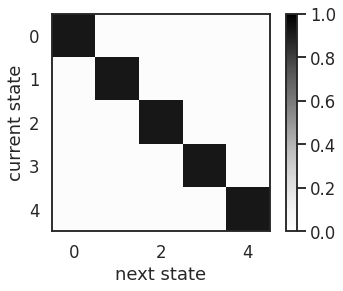

In [4]:
num_states = 5
num_channels = 10

transition_matrix = 0.90 * np.eye(num_states) + 0.10 * np.ones((num_states, num_states)) / num_states

true_hmm = BernoulliHMM(
    num_states, num_emission_dims=num_channels, transition_matrix=transition_matrix, seed=jr.PRNGKey(0)
)
plot_transition_matrix(true_hmm.transition_matrix)

### From the true model, we can sample synthetic data

In [5]:
rng = jr.PRNGKey(0)
num_timesteps = 500

states, data = true_hmm.sample(rng, num_timesteps)

### Let's view the synthetic data

/home/vishal/anaconda3/envs/pyprob/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/home/vishal/anaconda3/envs/pyprob/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


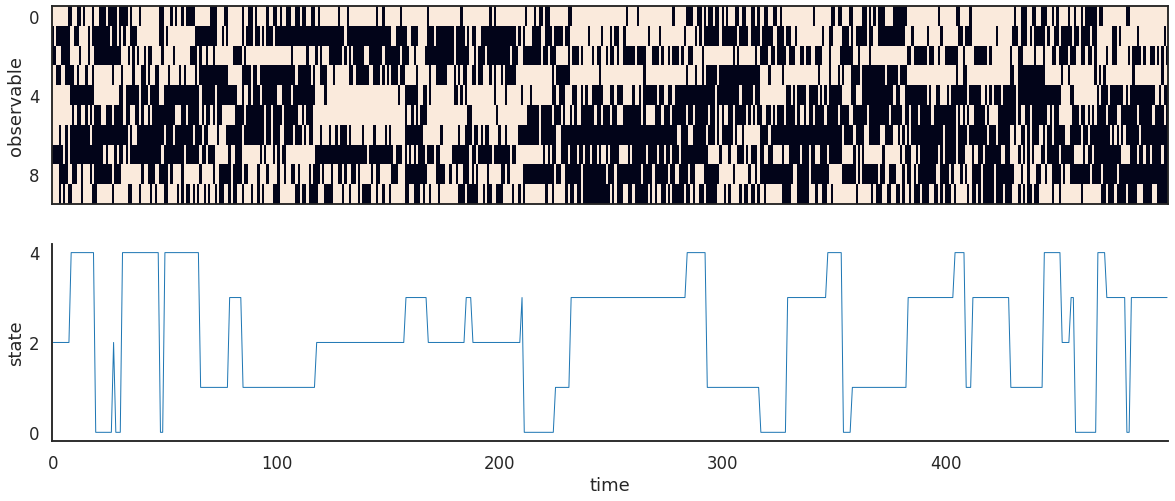

In [6]:
latexify(width_scale_factor=1, fig_height=2)
figsize = (20, 8)
if is_latexify_enabled():
    figsize = None
fig, axs = plt.subplots(2, 1, sharex=True, figsize=figsize)
axs[0].imshow(data.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("observable")
axs[0].set_yticks([0, 4, 8])
axs[1].plot(states, linewidth=1)
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
axs[1].set_yticks([0, 2, 4])
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
savefig("bernoulli-hmm-data")
plt.show()

## Fit HMM using exact EM update

In [7]:
test_hmm = BernoulliHMM(num_states, num_channels, seed=jr.PRNGKey(32))
lps, test_hmm, posterior = test_hmm.fit(data, method="em", tol=-1)

Initializing...
Done.


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'log likelihood')

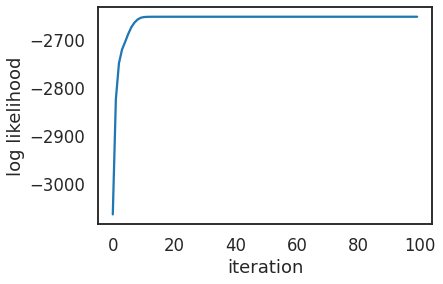

In [8]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

In [9]:
test_hmm.transition_matrix

DeviceArray([[0.9361332 , 0.01220626, 0.01064176, 0.03129838, 0.00972044],
             [0.0268772 , 0.849152  , 0.07304412, 0.04904638, 0.00188023],
             [0.0501412 , 0.06562799, 0.8506931 , 0.03183501, 0.00170273],
             [0.01370143, 0.00975707, 0.02332079, 0.9331732 , 0.02004753],
             [0.00111887, 0.00132545, 0.02881317, 0.02912629, 0.9396162 ]],            dtype=float32)

/home/vishal/anaconda3/envs/pyprob/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


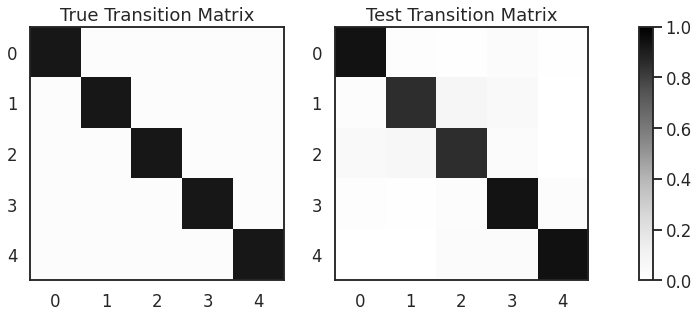

In [10]:
# Compare the transition matrices

compare_transition_matrix(true_hmm.transition_matrix, test_hmm.transition_matrix)

# savefig("bernoulli-hmm-transmat-comparison")

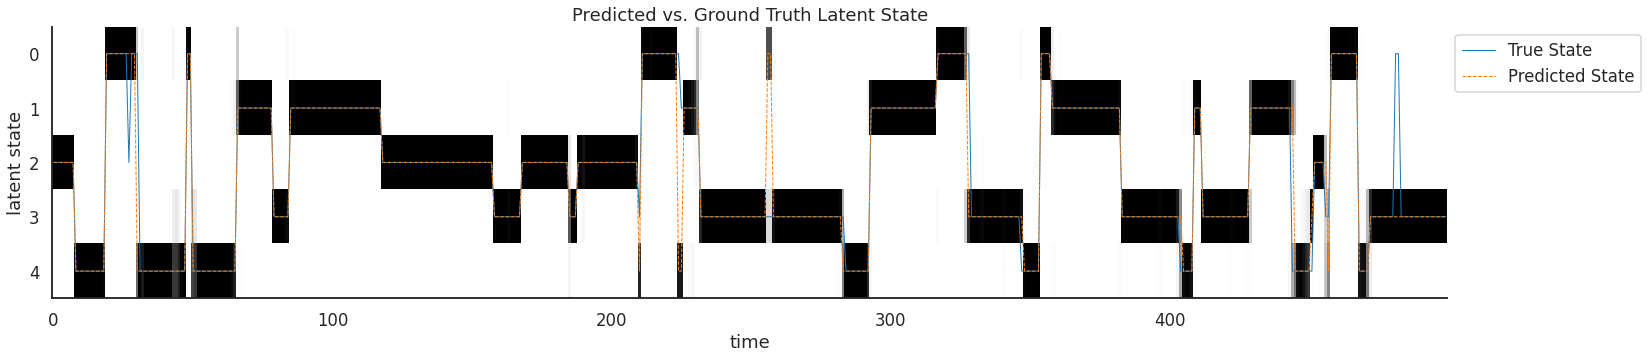

In [11]:
# Posterior distribution
Ez = posterior.expected_states.reshape(-1, num_states)
perm = find_permutation(states, np.argmax(Ez, axis=-1))
plot_posterior_states(Ez, states, perm)
# savefig("bernoulli-hmm-state-est-comparison")
sns.despine()
plt.show()

# Fit Bernoulli Over Multiple Trials

In [12]:
rng = jr.PRNGKey(0)
num_timesteps = 500
num_trials = 5

all_states, all_data = true_hmm.sample(rng, num_timesteps, num_samples=num_trials)

In [13]:
# Now we have a batch dimension of size `num_trials`
print(all_states.shape)
print(all_data.shape)

(5, 500)
(5, 500, 10)


In [14]:
lps, test_hmm, posterior = test_hmm.fit(all_data, method="em", tol=-1)

Initializing...
Done.


  0%|          | 0/100 [00:00<?, ?it/s]

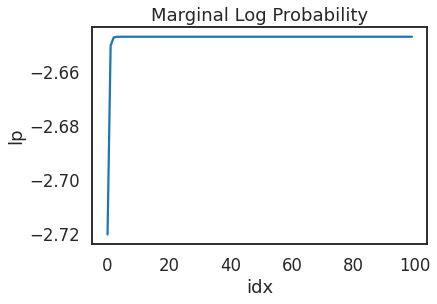

/home/vishal/anaconda3/envs/pyprob/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


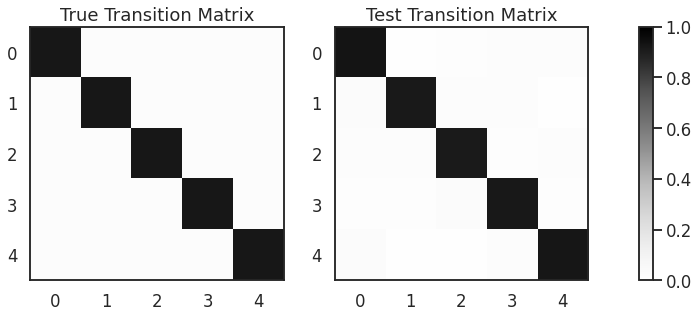

In [15]:
# plot marginal log probabilities
plt.figure()
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(lps / data.size)
plt.show()

compare_transition_matrix(true_hmm.transition_matrix, test_hmm.transition_matrix)

===== Trial: 0 =====


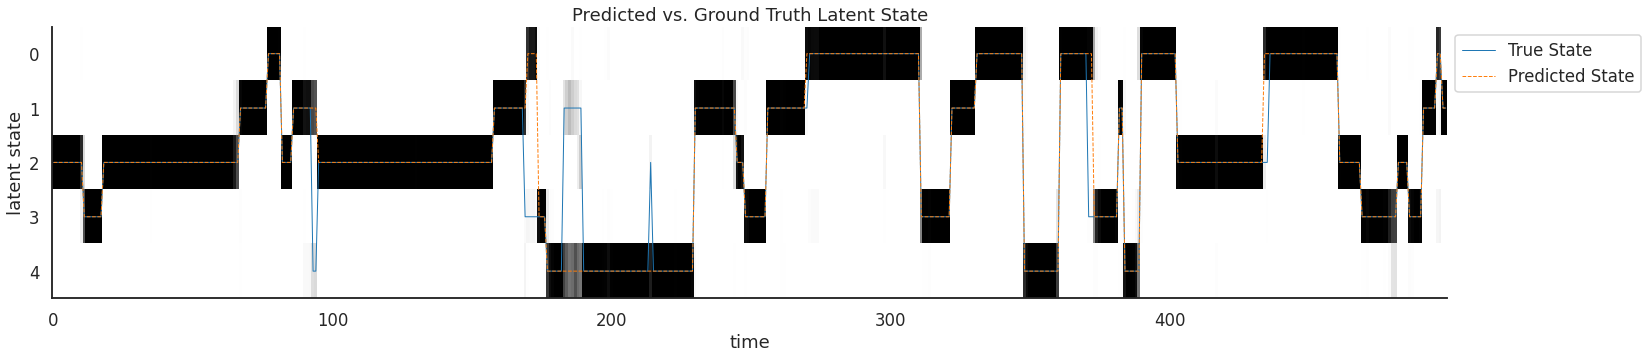

===== Trial: 1 =====


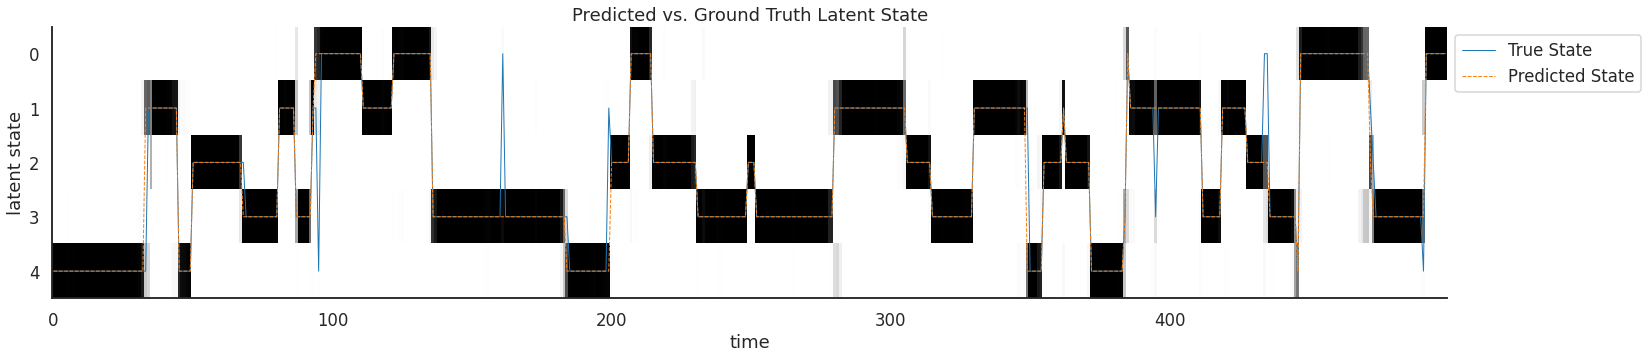

===== Trial: 2 =====


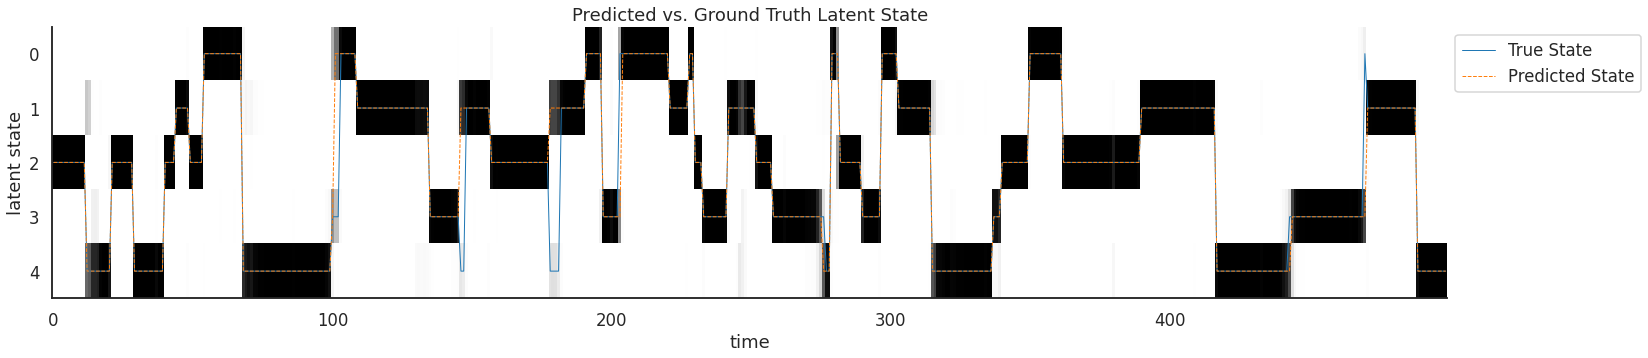

In [16]:
# For the first few trials, let's see how good our predicted states are
for trial_idx in range(3):
    print("=" * 5, f"Trial: {trial_idx}", "=" * 5)
    Ez = posterior.expected_states[trial_idx]
    states = all_states[trial_idx]
    perm = find_permutation(states, np.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)
    sns.despine()
    plt.show()